Link to our folder: https://drive.google.com/drive/folders/1Lnydst2NJ1k0tU2SvVR5g5AqA2nToomN?usp=sharing

<b><h1>HOMEWORK 2 🕐 </h1></b>

> In the assigned task, one is tasked with predicting future samples of the input time series. The objective is to design and implement forecasting models to understand how to leverage past observations in input sequences to accurately predict the future. The goal is to develop a forecasting model capable of predicting several uncorrelated time series. The prerequisite is that the model demonstrates generalization capabilities in the forecasting domain, enabling it to go beyond the constraints of specific time domains. This necessitates a model that, while specialized in forecasting, is not confined to predicting within a single or predefined time context.

## 👨‍👨‍👧‍👦 Our team group - ANN
- ```Balestrieri Niccolò - 10936955```
- ```Bertogalli Andrea - 10702303```
- ```Tombini Nicolò - 10912627```

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import os.path
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import logging
import random
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
!pip install attention
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from attention import Attention
from imblearn.over_sampling import SMOTE, RandomOverSampler
import tensorflow.keras as tfk
from tensorflow.keras.models import Model, load_model
from collections import Counter
from tensorflow.keras import layers, Model, backend as K
import keras
from keras import layers, Sequential
from keras.layers import Input, Add, multiply, Dense, LSTM, Bidirectional, Activation, Average, ZeroPadding1D, Cropping1D, Flatten, GlobalAveragePooling1D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout,concatenate, BatchNormalization, Reshape
from keras.models import Model
from sklearn.utils import class_weight
from tensorflow import keras as tfk
from keras.layers import *
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers as tfkl
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from scipy import stats
!pip install progress
import itertools as it
import keras
from progress.bar import IncrementalBar
import json
import sklearn
!pip install scikeras
from sklearn.utils import resample

seed = 42
random.seed(seed)
np.random.seed(seed)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

## 🔎 Dataset Load and dataset inspection

In this section of the notebook, the dataset is loaded and visually inspected in an attempt to understand the structure of time series within different categories. Subsequently, a cleaning operation was performed with the aim of eliminating duplicate series.

In [ ]:
training_data = np.load('/content/drive/My Drive/Homework2/dataset/raw/training_data.npy', allow_pickle=True)
valid_periods = np.load('/content/drive/My Drive/Homework2/dataset/raw/valid_periods.npy', allow_pickle=True)
categories = np.load('/content/drive/My Drive/Homework2/dataset/raw/categories.npy', allow_pickle=True)

[2776]


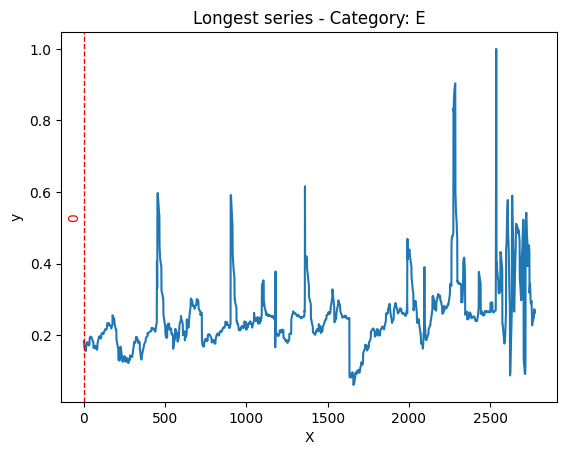

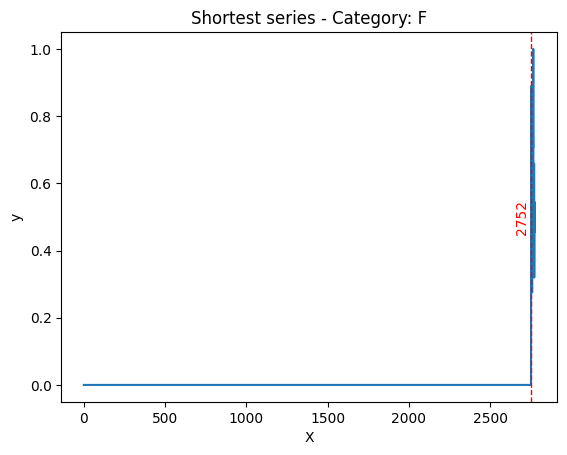

In [ ]:
# Check if all the series end at time point 2776
print(np.unique(np.max(valid_periods, axis=1)))

# Find the index of the longest and shortest series
longest_serie = np.argmin(np.min(valid_periods, axis=1))
shortest_serie = np.argmax(np.min(valid_periods, axis=1))

# Plot the longest series with a vertical line indicating the starting point
start = np.min(np.min(valid_periods, axis=1))
sns.lineplot(data=training_data[longest_serie])
plt.axvline(x=start, linestyle='--', color='red', linewidth=1)
plt.text(start - 100, np.mean(plt.ylim()), str(start), color='red', rotation=90, verticalalignment='center')
plt.title(f"Longest series - Category: {categories[longest_serie]}")
plt.ylabel("y")
plt.xlabel("X")
plt.show()

# Plot the shortest series with a vertical line indicating the starting point
start = np.max(np.min(valid_periods, axis=1))
sns.lineplot(data=training_data[shortest_serie])
plt.axvline(x=np.max(np.min(valid_periods, axis=1)), linestyle='--', color='red', linewidth=1)
plt.text(start - 100, np.mean(plt.ylim()), str(start), color='red', rotation=90, verticalalignment='center')
plt.title(f"Shortest series - Category: {categories[shortest_serie]}")
plt.ylabel("y")
plt.xlabel("X")
plt.show()

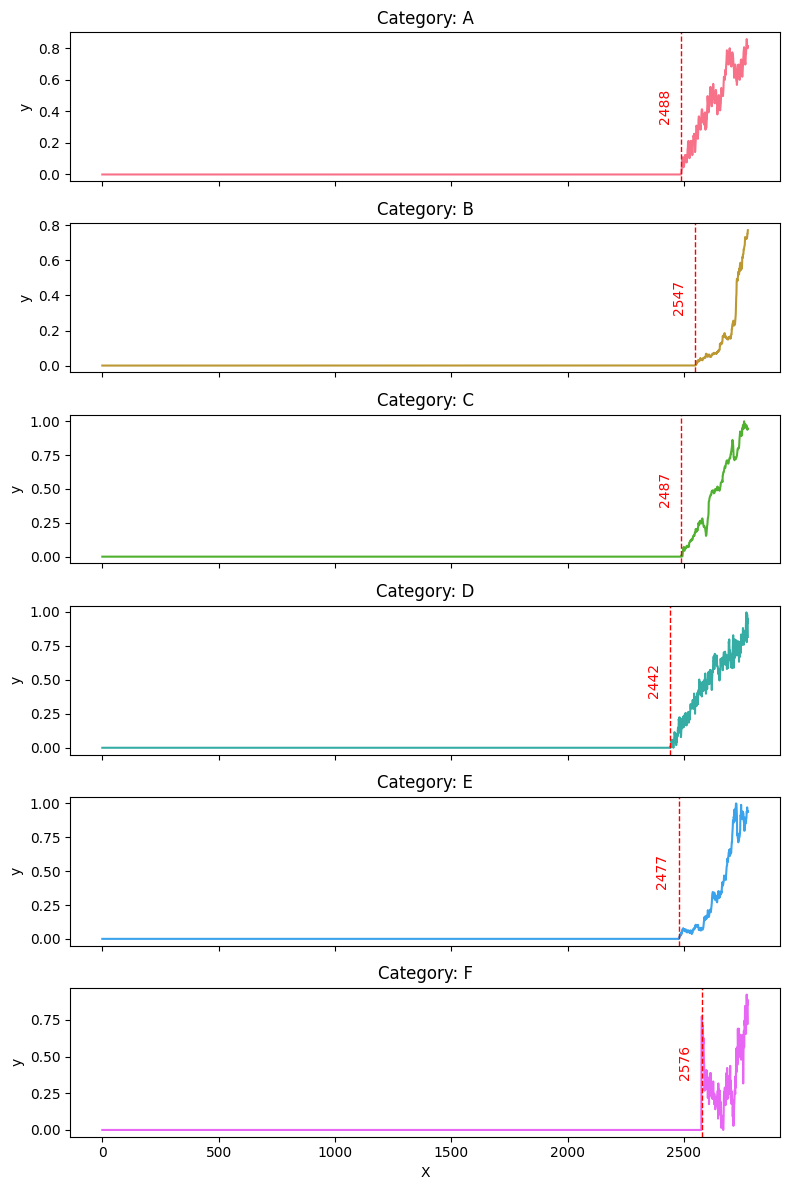

In [ ]:
# Obtain unique categories in the 'categories' array
unique_categories = np.unique(categories)

# Create a dictionary to store random indices for each unique category
random_indices = {}

# For each unique category, randomly select an index where the category occurs
for c in unique_categories:
    random_indices[c] = np.random.choice(np.where(categories == c)[0])

palette = sns.color_palette("husl", len(unique_categories))
fig, axes = plt.subplots(nrows=len(unique_categories), ncols=1, figsize=(8, 12), sharex=True)

# Iterate over unique categories and plot corresponding time series
for i, c in enumerate(unique_categories):
    sns.lineplot(data=training_data[random_indices[c]], ax=axes[i], color=palette[i])
    # From the valid period
    start_pt = np.min(valid_periods[random_indices[c]])
    axes[i].axvline(x=start_pt, linestyle='--', color='red', linewidth=1)
    axes[i].text(start_pt - 100, np.mean(axes[i].get_ylim()), str(start_pt), color='red', rotation=90, verticalalignment='center')
    axes[i].set_title(f"Category: {c}")
    axes[i].set_ylabel("y")

plt.xlabel("X")
plt.tight_layout()
plt.show()


In [ ]:
# Find unique rows and their corresponding indices in the 'training_data' array
u, indices = np.unique(training_data, return_index=True, axis=0)

# Identify the indices of rows that are not unique
r_indices = set(np.arange(0, len(training_data))) - set(indices)

# Remove non-unique rows (duplicate time series) from 'training_data', 'valid_periods', and 'categories'
training_data = np.delete(training_data, list(r_indices), axis=0)
valid_periods = np.delete(valid_periods, list(r_indices), axis=0)
categories = np.delete(categories, list(r_indices))

## 👀 Depth inspections

In this section, we focused on more in-depth analyses.

Initially, to identify potential outliers (flat signals), a linear regression was fitted to approximate the signals. Subsequently, the results were sorted in ascending order based on error and slope. The time series in the graph below corresponds to the one with the regression line (red line) that best approximates it. If the signal (blue graph) is not flat, then there are no outliers.

5.438395410475523e-07 0.26131693313383875 0.1343943262872203


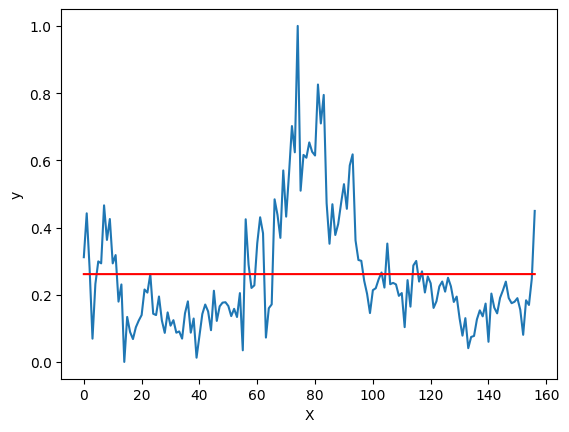

In [ ]:
slopes, intercepts, errs = [], [], []

# Iterate over valid periods and fit linear regression to each time series segment
for i, p in enumerate(valid_periods):
    slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(0, p[1] - p[0]), training_data[i][p[0]:p[1]])
    slopes.append(slope)
    intercepts.append(intercept)
    errs.append(np.mean(np.abs(slope * np.arange(0, p[1] - p[0]) + intercept - training_data[i][p[0]:p[1]])))

slopes = np.array(slopes)
intercepts = np.array(intercepts)
errs = np.array(errs)

# Sort the results based on error and slope
sorted_indices = np.lexsort((errs, slopes))
slopes = slopes[sorted_indices]
errs = errs[sorted_indices]
intercepts = intercepts[sorted_indices]
series = training_data[sorted_indices]
periods = valid_periods[sorted_indices]

# Find the index where the slope is greater than or equal to 0
i = np.where(slopes >= 0)[0][0]

print(slopes[i], intercepts[i], errs[i])
data = slopes[i] * np.arange(0, periods[i][1] - periods[i][0]) + intercepts[i]
sns.lineplot(data=series[i][periods[i][0]:periods[i][1]])
sns.lineplot(data=data, color='red')
plt.ylabel("y")
plt.xlabel("X")
plt.show()


In this case, the goal is to plot the distributions of the lengths of time series within the provided valid periods.

mu:  198.30022916666667 sigma:  137.40486378441685


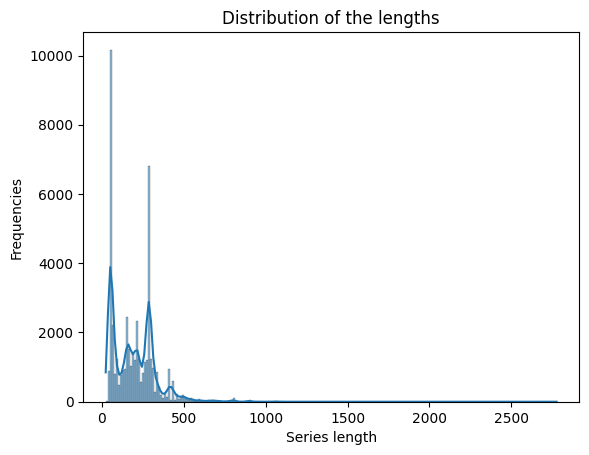

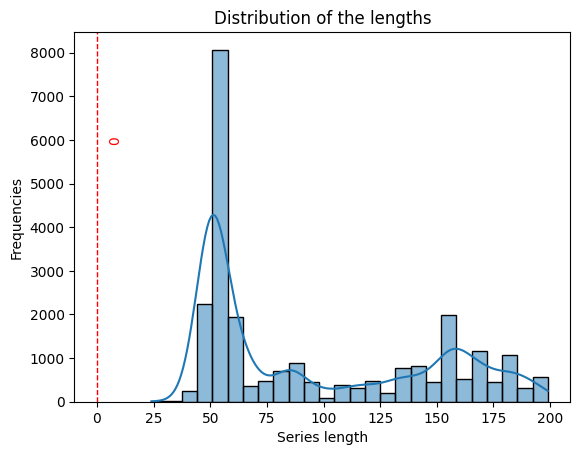

In [ ]:
length_distributions = np.max(valid_periods, axis=1) - np.min(valid_periods, axis=1)
mu = np.mean(length_distributions)
sigma = np.std(length_distributions)

print("mu: ", mu, "sigma: ", sigma)
sns.histplot(length_distributions, kde=True)
plt.xlabel('Series length')
plt.ylabel('Frequencies')
plt.title('Distribution of the lengths')
plt.show()

treshold = 0
print()

sns.histplot([x for x in length_distributions if x < 200], kde=True)
plt.axvline(x=treshold, linestyle='--', color='red', linewidth=1)
plt.text(treshold + 5, 6000, str(treshold), color='red', rotation=90, verticalalignment='center')
plt.xlabel('Series length')
plt.ylabel('Frequencies')
plt.title('Distribution of the lengths')
plt.show()

below_treshold_idxs = np.where(length_distributions <= treshold)[0]
training_data = np.delete(training_data, list(below_treshold_idxs), axis = 0)
valid_periods = np.delete(valid_periods, list(below_treshold_idxs), axis = 0)
categories = np.delete(categories, list(below_treshold_idxs))

Here we split the data into train and validation sets, stratifying them by category. Then the various windows are created to be subsequently provided to the models, starting from the entire time series loaded previously, also performing various padding operations.

In [ ]:
# Initialize a StratifiedShuffleSplit splitter with 80% training and 20% validation data
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

train_idx, val_idx = [], []

# Iterate over the splits and store the indices for training and validation sets
for train, val in splitter.split(training_data, categories):
    train_idx.append(train)
    val_idx.append(val)

train_idx = train_idx[0]
val_idx = val_idx[0]

# Create raw training and validation sets based on the obtained indices
X_train_raw = training_data[train_idx]
train_categories_raw = categories[train_idx]
train_periods_raw = valid_periods[train_idx]
X_val_raw = training_data[val_idx]
val_categories_raw = categories[val_idx]
val_periods_raw = valid_periods[val_idx]

print(X_train_raw.shape)
print(train_categories_raw.shape)
print(train_periods_raw.shape)
print(X_val_raw.shape)
print(val_categories_raw.shape)
print(val_periods_raw.shape)

cats, counts = np.unique(train_categories_raw, return_counts=True)
perc = (counts / len(train_categories_raw)) * 100
print(dict(zip(cats, perc)))

cats, counts = np.unique(val_categories_raw, return_counts=True)
perc = (counts / len(val_categories_raw)) * 100
print(dict(zip(cats, perc)))


In [ ]:
import math

def build_sequences(df, periods, categories, window=200, stride=6, telescope=18):
    X, y, cats = [], [], []

    # Iterate over each time series in the dataframe
    for row_idx, serie in enumerate(df):
        # Get the valid interval for the time series
        lower_bound, upper_bound = np.min(periods[row_idx]), np.max(periods[row_idx])

        # Check if the cut series is smaller than the window + telescope, then pad
        if (upper_bound - lower_bound) <= (window + telescope):
            # Replicate the series back in time to padding the window
            serie = np.tile(serie[lower_bound:upper_bound], math.ceil(window + telescope / (upper_bound - lower_bound)))
            upper_bound = len(serie)
            lower_bound = len(serie) - (window + telescope)

            X.append(serie[lower_bound:upper_bound - telescope])
            y.append(serie[upper_bound - telescope:upper_bound])
            cats.append(categories[row_idx])
            continue

        # Adjust the lower bound if the cut series is not splittable
        delta = 0
        z = upper_bound - (lower_bound + window + telescope)

        if (z % stride):
            delta = (stride - z) if z < stride else stride - (z % stride)
        lower_bound -= delta + 1

        cut_series = []

        # If the lower bound is negative, pad the series accordingly
        if lower_bound < 0:
            serie = np.pad(serie, (abs(lower_bound), 0), 'constant')
            cut_series = serie[0:upper_bound + abs(lower_bound)]
        else:
            cut_series = serie[lower_bound:upper_bound]

        # Build sequences with the specified window, stride, and telescope
        for idx in np.arange(0, len(cut_series) - window - telescope, stride):
            X.append(cut_series[idx:idx + window])
            y.append(cut_series[idx + window:idx + window + telescope])
            cats.append(categories[row_idx])

    return np.array(X), np.array(y), np.array(cats)

# Build sequences for the training set
X_train, y_train, train_categories = build_sequences(X_train_raw, train_periods_raw, train_categories_raw, window=200, stride=10, telescope=18)

# Build sequences for the validation set
X_val, y_val, val_categories = build_sequences(X_val_raw, val_periods_raw, val_categories_raw, window=200, stride=10, telescope=18)

In [ ]:
print(X_train.shape, y_train.shape, train_categories.shape)
np.save("/content/drive/My Drive/Homework2/dataset/X_train.npy", X_train)
np.save("/content/drive/My Drive/Homework2/dataset/y_train.npy", y_train)
np.save("/content/drive/My Drive/Homework2/dataset/train_categories.npy", train_categories)

print(X_val.shape, y_val.shape, val_categories.shape)
np.save("/content/drive/My Drive/Homework2/dataset/X_val.npy", X_val)
np.save("/content/drive/My Drive/Homework2/dataset/y_val.npy", y_val)
np.save("/content/drive/My Drive/Homework2/dataset/val_categories.npy", val_categories)

(201022, 200) (201022, 18) (191585,)
(50545, 200) (50545, 18) (48202,)


In [ ]:
X_train = np.load('/content/drive/My Drive/Homework2/dataset/X_train.npy', allow_pickle=True)
y_train = np.load('/content/drive/My Drive/Homework2/dataset/y_train.npy', allow_pickle=True)
train_categories = np.load('/content/drive/My Drive/Homework2/dataset/train_categories.npy', allow_pickle=True)
print(X_train.shape, y_train.shape, train_categories.shape)

X_val = np.load('/content/drive/My Drive/Homework2/dataset/X_val.npy', allow_pickle=True)
y_val= np.load('/content/drive/My Drive/Homework2/dataset/y_val.npy', allow_pickle=True)
val_categories = np.load('/content/drive/My Drive/Homework2/dataset/val_categories.npy', allow_pickle=True)
print(X_val.shape, y_val.shape, val_categories.shape)
X = np.concatenate((X_train, X_val), axis=0)
y = np.concatenate((y_train, y_val), axis=0)
categories = np.concatenate((train_categories, val_categories), axis=0)

print(X.shape)
print(y.shape)
print(categories.shape)

(213444, 200) (213444, 18) (190875,)
(54450, 200) (54450, 18) (48843,)
(267894, 200)
(267894, 18)
(239718,)


### 🔧 Utils

In [ ]:
def eval_model(X_val, y_val, history, model):
    # Evaluate the model on the validation data
    test_loss, mse, mae = model.evaluate(X_val, y_val, verbose=0)

    # Print the evaluation metrics
    print("MSE: ", mse)
    print("MAE: ", mae)

    # Plotting the training and validation loss over epochs
    plt.figure(figsize=(15,5))
    plt.plot(history['loss'], label='train_loss', alpha=.8, color='#000000')
    plt.plot(history['val_loss'], label='val_loss', alpha=.8, color='#FF0000')
    plt.legend(loc='upper left')
    plt.title('Loss: MSE')
    plt.grid(alpha=.3)

    # Plotting the training and validation MSE over epochs
    plt.figure(figsize=(15,5))
    plt.plot(history['mse'], label='train_mse', alpha=.8, color='#000000')
    plt.plot(history['val_mse'], label='val_mse', alpha=.8, color='#FF0000')
    plt.legend(loc='upper left')
    plt.title('MSE')
    plt.grid(alpha=.3)

    # Plotting the training and validation MAE over epochs
    plt.figure(figsize=(15,5))
    plt.plot(history['mae'], label='train_mae', alpha=.8, color='#000000')
    plt.plot(history['val_mae'], label='val_mae', alpha=.8, color='#FF0000')
    plt.legend(loc='upper left')
    plt.title('MAE')
    plt.grid(alpha=.3)

    plt.show()

## 📊 Model inspection

In this section, we are going to inspect some models to see which ones can best approach the time series forecasting problem: <br>


*   **BiLSTM + Conv1D**
*   **ResNet1D + CBAM**
*   **FFNN**
*   **Standard LSTM**

As can be seen from the results on our validation set and the charts, almost all the models exhibit very similar performance.

### BiLSTM + Conv1D

In [ ]:
def BiLSTM_Conv1D_builder():
  telescope = 18
  window = 200
  channels = 1

  input_layer = Input(shape=(window, channels), name='input_layer')
  x = Bidirectional(LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm1')(input_layer)
  x = Bidirectional(LSTM(128, return_sequences=True, name='lstm'), name='bidirectional_lstm2')(x)
  x = Attention(128)(x)
  x = Reshape((128,1))(x)
  x = Conv1D(128, 3, padding='same', activation='relu', name='conv1')(x)
  x = MaxPooling1D(pool_size = 2, strides = 2)(x)
  x = Conv1D(64, 3, padding='same', activation='relu', name='conv2')(x)
  x = MaxPooling1D(pool_size = 2, strides = 2)(x)
  x = Conv1D(32, 3, padding='same', activation='relu', name='conv3')(x)
  output_layer = Conv1D(channels, 1, padding='same', name='output_layer')(x)
  crop_size = output_layer.shape[1] - telescope
  output_layer = Cropping1D((0, crop_size), name='cropping')(output_layer)
  model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
  model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae"])

  return model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)

model = BiLSTM_Conv1D_builder()
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])

eval_model(X_val, y_val, history.history, model)

We reached: <br>
MSE:  0.0070 <br>
MAE:  0.0533

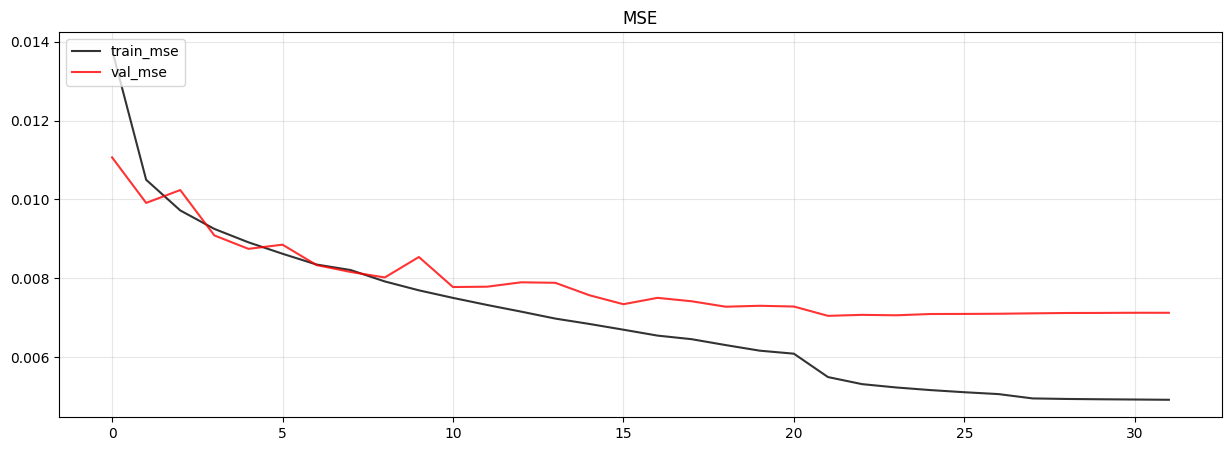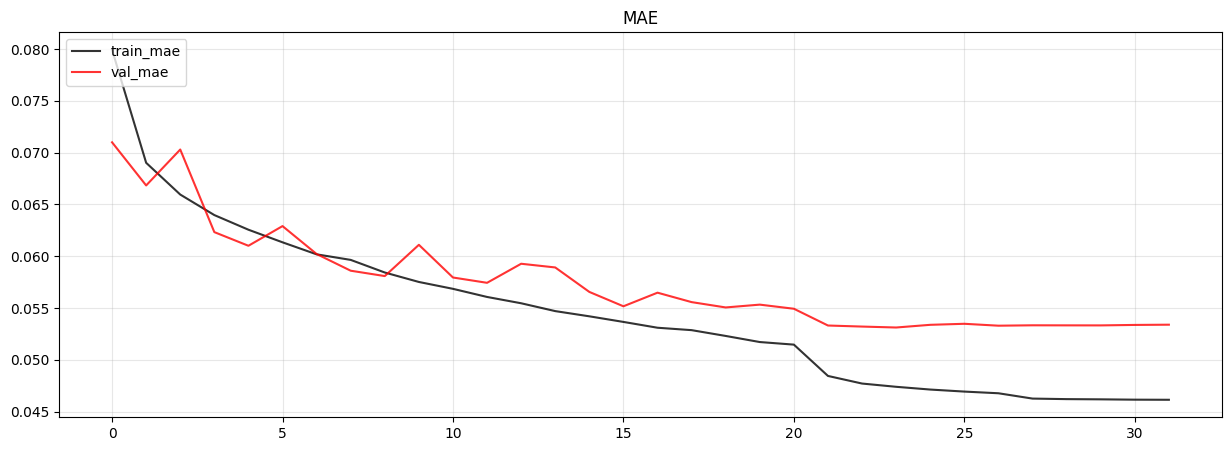




### ResNet1D + CBAM

In [ ]:
def CBAM_block(in_block, ch, ratio=16):

    # 1. Channel attention
    avg_pool = tf.reduce_mean(in_block, axis = (1), keepdims = True)
    max_pool = tf.reduce_max(in_block, axis = (1), keepdims = True)

    dense1 = Dense(ch//ratio, activation = 'relu')
    avg_reduced = dense1(avg_pool)
    max_reduced = dense1(max_pool)

    dense2 = Dense(ch)
    avg_attention = dense2(avg_reduced)
    max_attention = dense2(max_reduced)

    x = tf.add(avg_attention, max_attention)
    x = tf.nn.sigmoid(x)
    x = tf.multiply(in_block, x)

    # 2. Spatial attention
    y_mean = tf.reduce_mean(x, axis = -1, keepdims=True)
    y_max = tf.reduce_max(x, axis=-1, keepdims=True)

    y = tf.concat([y_mean, y_max], axis = -1)
    y = tf.keras.layers.Conv1D(filters=1, kernel_size=7, padding='same', activation=tf.nn.sigmoid)(y)

    # 3. Combination
    y = tf.multiply(x, y)

    return y

# ResNet with Convolutional Block Attention Module definition
def ResBs_CBAM_Conv(block_input, num_filters):

    # 0. Filter Block input and BatchNormalization
    block_input_short = Conv1D(num_filters, kernel_size=7, strides=2,  padding = 'valid')(block_input)
    block_input_short = BatchNormalization()(block_input_short)

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, strides=2, padding= 'valid')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout)
    norm2 = BatchNormalization()(conv2)

    CBAM = CBAM_block(norm2, num_filters, ratio=16)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input_short, CBAM])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

def ResBs_CBAM_Identity(block_input, num_filters):

    # 1. First Convolutional Layer
    conv1 = Conv1D(filters=num_filters, kernel_size=7, padding= 'same')(block_input)
    norm1 = BatchNormalization()(conv1)
    relu1 = Activation('relu')(norm1)
    dropout = Dropout(0.2)(relu1)

    # 2. Second Convolutional Layer
    conv2 = Conv1D(num_filters, kernel_size=7, padding= 'same')(dropout)
    norm2 = BatchNormalization()(conv2)

    CBAM = CBAM_block(norm2, num_filters, ratio=16)

    # 3. Summing Layer (adding a residual connection)
    sum = Add()([block_input, CBAM])

    # 4. Activation Layer
    relu2 = Activation('relu')(sum)

    return relu2

# model integrating deep + wide
def resnet_CBAM_deep_wide(N=8, ch=1, win_len=200, telescope=18):
    inputs = Input(shape=(win_len, ch))

    ResNet = Conv1D(filters=64,kernel_size=15, padding = 'same')(inputs)
    ResNet = BatchNormalization()(ResNet)
    ResNet = Activation('relu')(ResNet)
    ResNet = MaxPooling1D(pool_size=2, strides = 2)(ResNet)

    # First two ResNet blocks are identity blocks
    ResNet = ResBs_CBAM_Identity(ResNet, 64)
    ResNet = ResBs_CBAM_Identity(ResNet, 64)

    filters = 64
    M = int((N - 2)/2)
    for i in range(M):
        filters = filters*2

        # define N-th ResBs block
        ResNet = ResBs_CBAM_Conv(ResNet, filters)
        ResNet = ResBs_CBAM_Identity(ResNet, filters)

    ResNet = GlobalMaxPooling1D(name='gmp_layer')(ResNet)
    ResNet = Flatten()(ResNet)

    x = tfkl.Dense(units=64, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2', kernel_regularizer=tf.keras.regularizers.l2(2e-5))(ResNet)
    x = tfkl.Activation('relu', name='HiddenActivation2')(x)
    outputs = Dense(telescope)(x)

    # Finally the model is composed by connecting inputs to outputs:
    model = Model(inputs=[inputs],outputs=outputs)

    return model

def ResNet_CBAM_builder():
  resnet_CBAM_deep_wide_model = resnet_CBAM_deep_wide(N=5, ch=1, win_len=200, telescope=18)
  resnet_CBAM_deep_wide_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae"])

  return resnet_CBAM_deep_wide_model

In [ ]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)

resnet_CBAM_deep_wide_model = ResNet_CBAM_builder()

history = resnet_CBAM_deep_wide_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [
        early_stopping, lr_scheduler
    ]
).history

eval_model(X_val, y_val, history, resnet_CBAM_deep_wide_model)

We reached: <br>
MSE:  0.0077 <br>
MAE:  0.0568

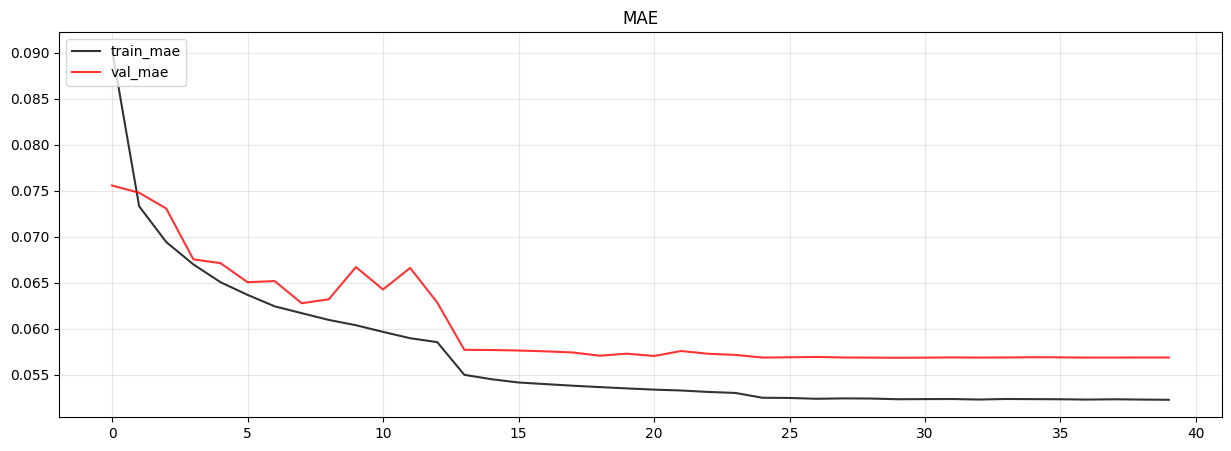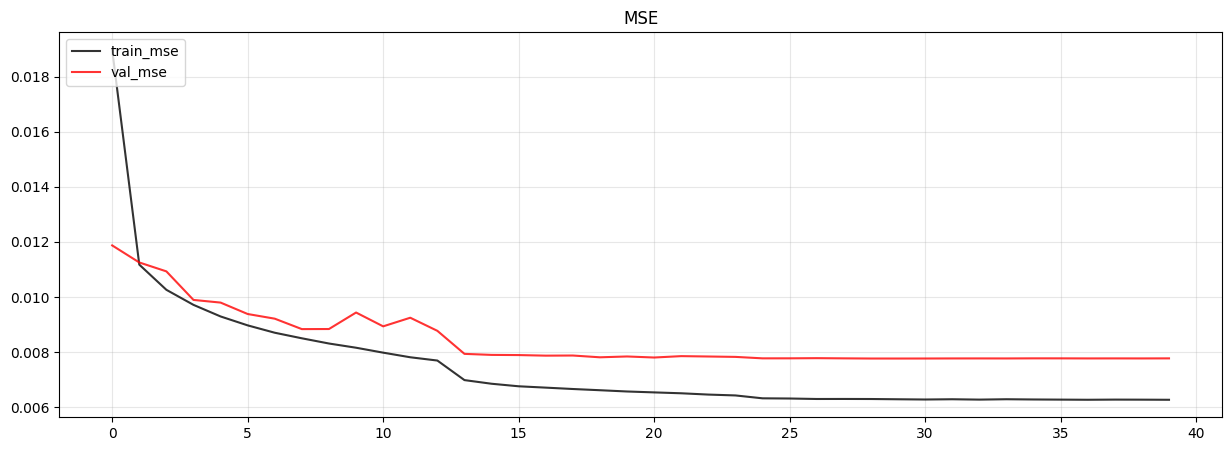

### FFNN

In [ ]:
def FFNN_builder():
  window = 200
  telescope = 18

  inputs = Input(shape=(window))
  x = Dense(units=2048, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense0')(inputs)
  x = Activation('relu', name='HiddenActivation1000')(x)
  x = Dense(units=1024, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(x)
  x = Activation('relu', name='HiddenActivation100')(x)
  x = Dense(units=512, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense100')(x)
  x = Activation('relu', name='HiddenActivation1')(x)
  x = Dense(units=256, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense2')(x)
  x = Activation('relu', name='HiddenActivation2')(x)
  x = Dense(units=128, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense3')(x)
  x = Activation('relu', name='HiddenActivation3')(x)
  x = Dense(units=64, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense4')(x)
  x = Activation('relu', name='HiddenActivation4')(x)
  x = Dense(units=32, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='HiddenDense5')(x)
  x = Activation('relu', name='HiddenActivation5')(x)
  output_layer = Dense(units=telescope, kernel_initializer=tfk.initializers.GlorotUniform(seed=seed),name='Output')(x)
  output_activation = Activation('linear', name='OutputActivation')(output_layer)
  ffnn_model = tfk.Model(inputs=inputs, outputs=output_activation, name='baseline_model')
  ffnn_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae"])

  return ffnn_model

In [ ]:
ffnn_model = FFNN_builder()

history = ffnn_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history

eval_model(X_val, y_val, history, ffnn_model)

We reached:<br>
MSE:  0.0079 <br>
MAE:  0.0574 <br>

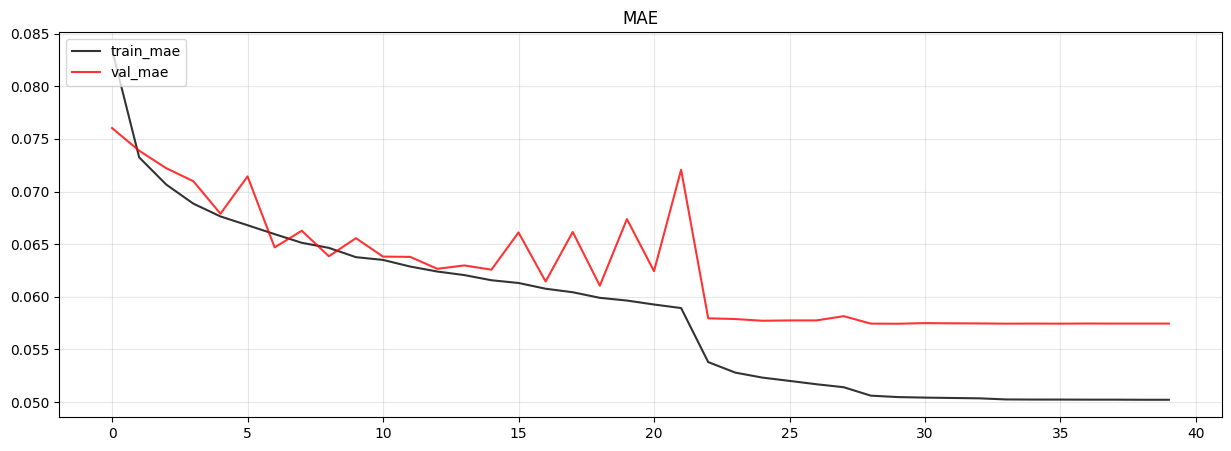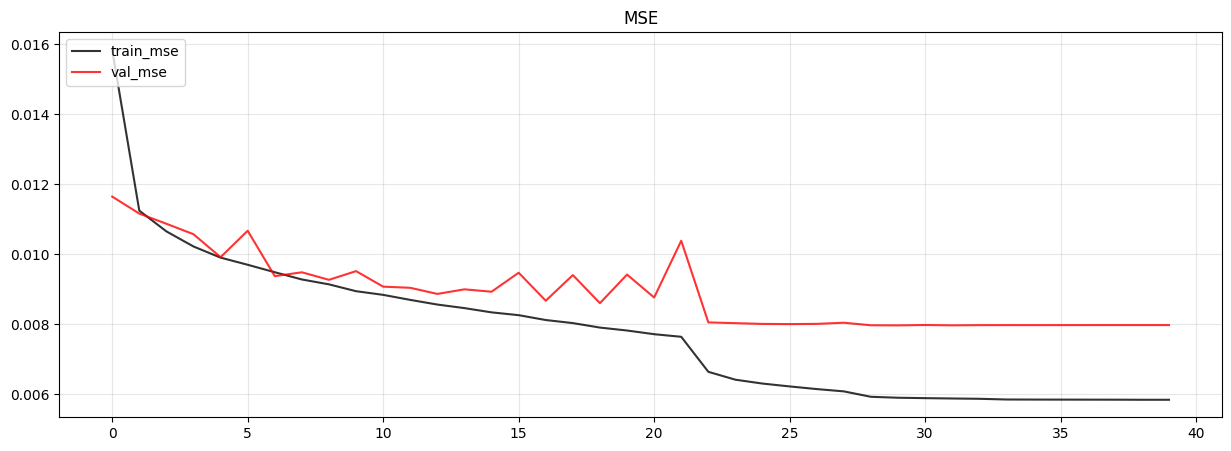

### Standard LSTM

In [ ]:
def Standard_LSTM_builder():
  telescope = 18
  window = 200

  inputs= Input(shape=(window, 1))
  x = Bidirectional(LSTM(256, return_sequences=True))(inputs)
  x = Attention(64, name="att")(x)
  x = Dense(units=64, kernel_initializer = tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(x)
  x = Activation('relu', name='HiddenActivation1')(x)
  x = Dense(32, name='HiddenDense2')(x)
  x = Activation('relu', name='HiddenActivation2')(x)
  outputs = Dense(telescope, name='output')(x)
  outputs = Activation('linear', name='outputActivation')(outputs)

  standard_lstm_model = Model(inputs=inputs, outputs=outputs)
  standard_lstm_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae"])

  return standard_lstm_model

In [ ]:
standard_lstm_model = Standard_LSTM_builder()

history = standard_lstm_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = 200,
    validation_data = (X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
).history

eval_model(X_val, y_val, history, standard_lstm_model)

We reached:

MSE:  0.0068 <br>
MAE:  0.0520

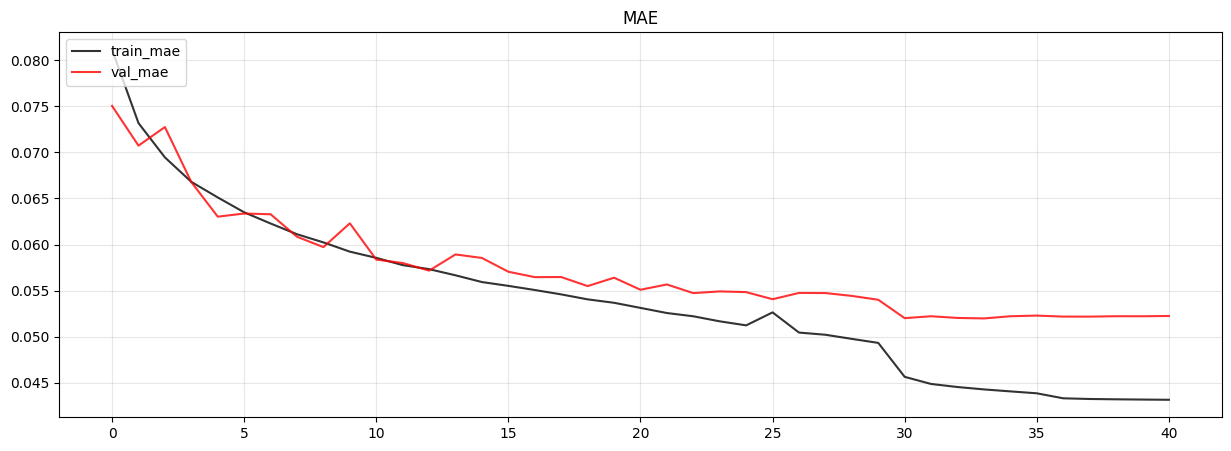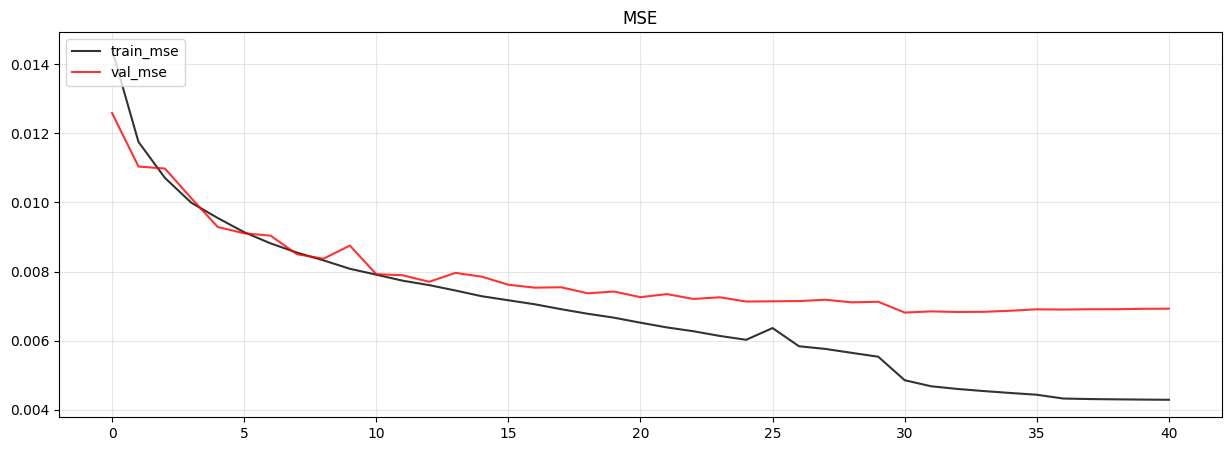

## ⭕ Model ensemble

Given the results from the previous section, here we have delved into the concept of an ensemble. The idea was to train the models seen above, all with the same dataset, and finally take an average of the predictions. This approach aims to reduce the variance of each individual model.

### 🔧 Utils

In [ ]:
def grid_search(model_builder, parameters_grid, X_train, y_train, X_val, y_val, name):
    # Initialize lists and combinations for grid search
    parameter_sets = []
    combinations = it.product(*(parameters_grid[x] for x in parameters_grid))
    params = parameters_grid.keys()
    grid_iterations = []
    for c in combinations:
        grid_iterations.append(dict(zip(params, c)))

    suffix = '%(percent)d%% [Elapsed time: %(elapsed_td)s]'
    with IncrementalBar("(G. Search) Progress: ", suffix=suffix, max=len(grid_iterations), color='magenta') as bar:
        for combination in grid_iterations:
            # Extract hyperparameters for the current iteration
            batch_size = combination.get("batch_size")
            lr = combination.get("min_lr")

            # Set up callbacks for the model
            early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)
            lr_scheduler = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=lr)

            # Build the model using the provided model
            model = model_builder()

            # Train the model and collect training history
            history = model.fit(X_train, y_train, epochs=200, batch_size=batch_size, validation_data=(X_val, y_val),
                                callbacks=[early_stopping, lr_scheduler])

            # Evaluate the model on the validation data
            loss, mse, mae = model.evaluate(X_val, y_val, verbose=0)

            # Store the results in parameter_sets list
            parameter_sets.append({
                "Eval": {
                    "mse": mse,
                    "mae": mae,
                    "Loss": loss,
                },
                "Parameters_set": {
                    "batch_size": batch_size,
                    "adam_learning_rate": lr
                }
            })

            # Save the results to a JSON file
            with open(f"/content/drive/My Drive/Homework2/gridsearch_checkpoints/{name}.json", 'w') as f:
                json.dump(parameter_sets, f, indent=4)
            model.save('/content/drive/My Drive/Homework2/models/' + name + '_' + str(batch_size) + '_lr_' + str(lr))
            bar.next()

    # Find the best set based on the evaluation metric (accuracy in this case)
    max_accuracy = 0
    best_set = {}
    for s in parameter_sets:
        if s["Eval"]["mean_squared_error"] > max_accuracy:
            max_accuracy = s["Eval"]["mean_squared_error"]
            best_set = s

    return best_set["Eval"], best_set["Parameters_set"]


### 🏋️ Ensemble with base models
In this section, the base models of the previously proposed architectures are loaded, and they are concatenated together through an Average layer responsible for computing the mean of the results.

In [ ]:
def load_ensemble_models(m1, m2, m3, m4):
  base_path = "/content/drive/My Drive/Homework2/models/"
  models_names = [m1, m2, m3, m4]
  models = []
  telescope = 18

  for name in models_names:
    # Load the model from the specified path
    model = load_model(f"{base_path}/{name}")

    # Check if the last layer of the loaded model has 3 dimensions
    if len(model.layers[-1].output_shape) == 3:
      # Reshape the output of the last layer to have a fixed shape (telescope,)
      output_of_loaded_model = model.layers[-1].output
      reshaped_output = Reshape((telescope,), name="FixShape")(output_of_loaded_model)

      model = Model(inputs=model.input, outputs=reshaped_output)
      model.compile()

    model._name = name
    models.append(model)

  return models

In [ ]:
window = 200

# Load ensemble models
models = load_ensemble_models("BiLSTM_CONV_base", "BiLSTM_base", "FFNN_base", "ResNet_CBAM_base")

# Define input layer for the ensemble model with a shape corresponding to the chosen window size
model_input = Input(shape=(window, 1))

# Generate model outputs by passing the input through each individual model in the ensemble
model_outputs = [model(model_input) for model in models]

# Calculate the ensemble output by taking the average of the individual model outputs
ensemble_output = Average()(model_outputs)

# Create the ensemble model with the specified input and output
ensemble_model = Model(inputs=model_input, outputs=ensemble_output)


ensemble_model.summary()
ensemble_model.compile(metrics=['mse', 'mae'])
tf.keras.utils.plot_model(ensemble_model)

# Evaluate the ensemble model on the validation data and store the results
result = ensemble_model.evaluate(X_val, y_val, verbose=0)

We obtained on our validation set: <br>
MSE: 0.0062 <br>
MAE: 0.050

### 🏋️ Ensemble with tuned models

To optimize the process and to achieve better performances, we used EarlyStopping and ReduceLROnPlateau, performing hyperparameter tuning for each model, including batch_size and minimum learning rate.

#### FFNN - Tuned

In [ ]:
grid = {
    "batch_size": [512, 256, 128, 64],
    "min_lr": [1e-5, 1e-8]
}

grd_evals, grd_params = grid_search(
                            FFNN_builder,
                            grid,
                            X_train,
                            y_train,
                            X_val,
                            y_val,
                            "FFNN_Tuned")

We have found that the optimal configuration for this network is with a batch size of 256, a minimum learning rate of 1e-05 (starting from 1e-3, 1e-4 at 29 epoch and 1e-5 at 35 epoch) and 35 as epoch: <br>

MSE: 0.0074 <br>
MAE: 0.055

#### BiLSTM + Conv1D - Tuned

In [ ]:
grid = {
    "batch_size": [512, 256, 128, 64],
    "min_lr": [1e-5, 1e-8]
}

grd_evals, grd_params = grid_search(
                            BiLSTM_Conv1D_builder,
                            grid,
                            X_train,
                            y_train,
                            X_val,
                            y_val,
                            "BiLSTM_Conv1D_Tuned")

We have found that the optimal configuration for this network is with a batch size of 64, a minimum learning rate of 1e-08 (starting from 1e-3, 1e-4 at 22 epoch) and 22 as epoch: <br>

MSE: 0.0070 <br>
MAE: 0.053

#### ResNet1D + CBAM - Tuned

In [ ]:
grid = {
    "batch_size": [512, 256, 128, 64],
    "min_lr": [1e-5, 1e-8]
}

grd_evals, grd_params = grid_search(
                            ResNet_CBAM_builder,
                            grid,
                            X_train,
                            y_train,
                            X_val,
                            y_val,
                            "ResNet_Tuned")

We have found that the optimal configuration for this network is with a batch size of 64, a minimum learning rate of 1e-08 (starting from 1e-3, 1e-4 at 23 epoch, 1e-5 at 29 epoch, 1e-6 at 34 epoch and 1e-7 at 39 epoch) and 41 as epoch:

MSE: 0.0075 <br>
MAE: 0.055


#### Standard LSTM - Finetuning

In [ ]:
grid = {
    "batch_size": [512, 256, 128, 64],
    "min_lr": [1e-5, 1e-8]
}

grd_evals, grd_params = grid_search(
                            Standard_LSTM_builder,
                            grid,
                            X_train,
                            y_train,
                            X_val,
                            y_val,
                            "StdLSTM_Tuned")

We have found that the optimal configuration for this network is with a batch size of 64, minimum learning rate of 1e-08 (starting from 1e-3, 1e-4 at 24 epoch) and 26 as epoch:

MSE: 0.0068 <br>
MAE: 0.052

#### Ensemble - Tuned models

In [ ]:
window = 200

# Load ensemble models
models = load_ensemble_models("BiLSTM_CONV_Tuned", "BiLSTM_Tuned", "FFNN_Tuned", "ResNet_CBAM_Tuned")

# Define input layer for the ensemble model with a shape corresponding to the chosen window size
model_input = Input(shape=(window, 1))

# Generate model outputs by passing the input through each individual model in the ensemble
model_outputs = [model(model_input) for model in models]

# Calculate the ensemble output by taking the average of the individual model outputs
ensemble_output = Average()(model_outputs)

# Create the ensemble model with the specified input and output
ensemble_model = Model(inputs=model_input, outputs=ensemble_output)


ensemble_model.summary()
ensemble_model.compile(metrics=['mse', 'mae'])
tf.keras.utils.plot_model(ensemble_model)

# Evaluate the ensemble model on the validation data and store the results
result = ensemble_model.evaluate(X_val, y_val, verbose=0)
print(result)

We obtained on our validation set: <br>
MSE: 0.0061 <br>
MAE: 0.049

We obtained on the first hidden test set the following results: <br>

MSE: 0.0053 <br>
MAE: 0.051

They are lower wrt our hold out validation set because we trained our model directly with a telescope of 18.



## 📚 Final train on all data
In this section, the training of all models on all data (training + validation) was performed. Subsequently, the ensemble was applied again to average the predictions of each individual model.

### 🔧 Utils

In [ ]:
from tensorflow.keras.callbacks import Callback

# Method that allows us to have a lr decay during the training phase with all the data
class CustomScheduler(Callback):
    def __init__(self, factor, epochs_list):
        super(CustomScheduler, self).__init__()
        self.factor = factor
        self.epochs_list = epochs_list

    def on_epoch_end(self, epoch, logs=None):
        # Print the current learning rate and epoch
        print(f" LR: {tf.keras.backend.get_value(self.model.optimizer.learning_rate)}")
        print(epoch)

        # Check if the current epoch plus 1 is in the specified list of epochs
        if epoch + 1 in self.epochs_list:
            # Get the current learning rate
            lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))

            # Calculate the new learning rate by multiplying with the specified factor
            new_lr = lr * self.factor

            # Set the new learning rate in the optimizer
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)

            print(f'\nLearning rate changed to {new_lr} at epoch {epoch + 1}')

### BiLSTM + Conv1D - Full

In [ ]:
scheduler = CustomScheduler(0.1, [21])

model = BiLSTM_Conv1D_builder()

history = model.fit(
    x = X,
    y = y,
    batch_size = 64,
    epochs = 22,
    callbacks = [
        scheduler
    ]
).history

### ResNet1D + CBAM

In [ ]:
scheduler = CustomScheduler(0.1, [22, 28, 33, 38])

resnet_CBAM_deep_wide_model = ResNet_CBAM_builder()

history = resnet_CBAM_deep_wide_model.fit(
    x = X,
    y = y,
    batch_size = 64,
    epochs = 41,
    callbacks = [
        scheduler
    ]
).history

### FFNN

In [ ]:
scheduler = CustomScheduler(0.1, [28,34])

model = FFNN_builder()

history = model.fit(X, y, epochs=35, batch_size=64, callbacks=[scheduler]).history

### Standard LSTM

In [ ]:
scheduler = CustomScheduler(0.1, [23])
model = Standard_LSTM_builder()

history = model.fit(X, y, epochs=26, batch_size=64, callbacks=[scheduler]).history

### Ensemble - Final models

In [ ]:
window = 200

# Load ensemble models
models = load_ensemble_models("RESNET_FULL_SMOTE", "LSTM_FULL_SMOTE", "FFNN_FULL_SMOTE", "BiLSTM_CONV_FULL_SMOTE")

# Define input layer for the ensemble model with a shape corresponding to the chosen window size
model_input = Input(shape=(window, 1))

# Generate model outputs by passing the input through each individual model in the ensemble
model_outputs = [model(model_input) for model in models]

# Calculate the ensemble output by taking the average of the individual model outputs
ensemble_output = Average()(model_outputs)

# Create the ensemble model with the specified input and output
ensemble_model = Model(inputs=model_input, outputs=ensemble_output)

ensemble_model.summary()
ensemble_model.compile(metrics=['mse', 'mae'])
tf.keras.utils.plot_model(ensemble_model)

ensemble_model.save('/content/drive/My Drive/Homework2/models/ENSEMBLE_FULL_SMOTE')

We obtained on the second hidden test set the following results: <br>

MSE: 0.011 <br>
MAE: 0.072



## ➕ Further Trials

In this challenge, in addition to the proposed solution, we simultaneously explored various approaches, which we report for completeness in the cells below. <br>
Unfortunately, they didn't work so well and so we decided to migrate our choices somewhere else.

### Data augmentation with SMOTE

We also explored the SMOTE technique in an attempt to synthetically generate time series belonging to categories with fewer instances compared to others.

In [ ]:
def count_categories(categories):
    # Count occurrences for each category
    occurrences = Counter(categories)

    for category, count in occurrences.items():
        print(f"Number of '{category}': {count}")

    # Find the most common category and its occurrences
    most_common_category, max_occurrences = occurrences.most_common(1)[0]
    print(f"Max occurrences '{most_common_category}' with {max_occurrences} occurrences.")

    return max_occurrences

# Count categories for training and validation datasets
max_occurrences_train = count_categories(train_categories)
max_occurrences_val = count_categories(val_categories)

# Concatenate X and y arrays for training and validation datasets
X_train_with_telescope = np.concatenate((X_train, y_train), axis=1)
y_train_categories = train_categories
X_val_with_telescope = np.concatenate((X_val, y_val), axis=1)
y_val_categories = val_categories

print(X_train_with_telescope.shape)
print(y_train_categories.shape)
print(X_val_with_telescope.shape)
print(y_val_categories.shape)

# Create DataFrames for training and validation datasets
df_train = pd.DataFrame({
    'Window': [X_train_with_telescope[i, :] for i in range(X_train_with_telescope.shape[0])],
    'Categories': y_train_categories
})
df_val = pd.DataFrame({
    'Window': [X_val_with_telescope[i, :] for i in range(X_val_with_telescope.shape[0])],
    'Categories': y_val_categories
})

print(df_train.head())
print(df_train.shape)
print(df_val.head())
print(df_val.shape)

# Define a function for one-hot encoding and SMOTE oversampling
def smote_data(y_categories):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_categories)

    # One-hot encoding of the target values
    ohe = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    encoded_y = ohe.fit_transform(integer_encoded)
    y_encoded = encoded_y

    original_categories = label_encoder.classes_
    encoded_mapping = dict(zip(original_categories, label_encoder.transform(original_categories)))
    print("Original categories:", original_categories)
    print("Categories mapping:", encoded_mapping)

    return y_encoded

# Apply one-hot encoding and SMOTE to training and validation datasets
y_train_encoded = smote_data(y_train_categories)
smote = SMOTE(random_state=42, sampling_strategy={0: max_occurrences_train, 1: max_occurrences_train, 2: max_occurrences_train, 3: max_occurrences_train, 4: max_occurrences_train, 5: max_occurrences_train})
X_train_smote, y_train_smote = smote.fit_resample(X_train_with_telescope, y_train_encoded)

y_val_encoded = smote_data(y_val_categories)
smote = SMOTE(random_state=42, sampling_strategy={0: max_occurrences_val, 1: max_occurrences_val, 2: max_occurrences_val, 3: max_occurrences_val, 4: max_occurrences_val, 5: max_occurrences_val})
X_val_smote, y_val_smote = smote.fit_resample(X_val_with_telescope, y_val_encoded)

# Define a function to print occurrences after SMOTE
def new_occurrences(y_smote):
    occurrences_after_smote = Counter(y_smote.argmax(axis=1))
    print("Occurrences after SMOTE:", occurrences_after_smote)

new_occurrences(y_train_smote)
new_occurrences(y_val_smote)

# Define a function to extract X and y from the oversampled datasets
def new_X_y(X_smote):
    y_smote_with_telescope = np.empty((0, 18))
    X_smote_without_telescope = X_smote[:, :-18]
    y_smote_with_telescope = np.vstack((y_smote_with_telescope, X_smote[:, -18:]))

    print("New dimension X_smote_without_telescope:", X_smote_without_telescope.shape)
    print("New dimension y_smote_with_telescope:", y_smote_with_telescope.shape)

    return X_smote_without_telescope, y_smote_with_telescope

# Extract X and y from the oversampled training and validation datasets
X_train_new, y_train_new = new_X_y(X_train_smote)
X_val_new, y_val_new = new_X_y(X_val_smote)

print(X_train_new.shape)
print(y_train_new.shape)
print(X_val_new.shape)
print(y_val_new.shape)

# Save the oversampled datasets to files
np.save("/content/drive/My Drive/Homework2/dataset/smote/X_train_new.npy", X_train)
np.save("/content/drive/My Drive/Homework2/dataset/smote/y_train_new.npy", y_train)

np.save("/content/drive/My Drive/Homework2/dataset/smote/X_val_new.npy", X_val)
np.save("/content/drive/My Drive/Homework2/dataset/smote/y_val_new.npy", y_val)

# Concatenate X and y arrays for the combined dataset
X = np.concatenate((X_train_new, X_val_new), axis=0)
y = np.concatenate((y_train_new, y_val_new), axis=0)

# Save the combined dataset to files
np.save("/content/drive/My Drive/Homework2/dataset/smote/X.npy", X)
np.save("/content/drive/My Drive/Homework2/dataset/smote/y.npy", y)


### Ensemble with weighted average layer

In [ ]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, weights, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self._weights = weights

    def call(self, inputs):
        output = inputs[0] * self._weights[0]
        for i in range(1, len(inputs)):
            output += inputs[i] * self._weights[i]
        return output / sum(self._weights)

In [ ]:
# snippet to find the best weights for the ensemble
models = load_ensemble_models("BiLSTM_CONV_Tuned", "BiLSTM_Tuned", "FFNN_Tuned", "ResNet_CBAM_Tuned")

best  = 0.006116185802966356
bw = [0.9224340806182747, 0.9184934943957023, 0.598944584460229, 0.48860570802894787]
for i in range(1):
  w = [random.uniform(0, 1) for _ in range(len(models))]
  s = sum(w)
  norm = [x / s for x in w]
  model_input = Input(shape=(200,1))
  model_outputs = [model(model_input) for model in models]
  ensemble_output = WeightedAverageLayer(w)(model_outputs)
  ensemble_model = Model(inputs=model_input, outputs=ensemble_output)
  ensemble_model.compile(metrics=['mse', 'mae'])
  tf.keras.utils.plot_model(ensemble_model)
  result = ensemble_model.evaluate(X_val, y_val, verbose=0)
  print(result, w)
  if(result[1] < best):
    best = result[1]
    bw = w

print(best, bw)

model_input = Input(shape=(200,1))
model_outputs = [model(model_input) for model in models]
ensemble_output = WeightedAverageLayer(bw)(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.compile(metrics=['mse', 'mae'])
tf.keras.utils.plot_model(ensemble_model)
result = ensemble_model.evaluate(X_val, y_val, verbose=0)

### Time2Vec

In [ ]:
class T2V(Layer):
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)

    def build(self, input_shape):
      self.W = self.add_weight(name='W',shape=(input_shape[-1], self.output_dim),initializer='uniform',trainable=True)
      self.P = self.add_weight(name='P',shape=(input_shape[1], self.output_dim),initializer='uniform',trainable=True)
      self.w = self.add_weight(name='w',shape=(input_shape[1], 1),initializer='uniform',trainable=True)
      self.p = self.add_weight(name='p',shape=(input_shape[1], 1),initializer='uniform',trainable=True)
      super(T2V, self).build(input_shape)

    def call(self, x):
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        return K.concatenate([sin_trans, original], -1)

def T2V_NN(param, dim):
    inp = Input(shape=(dim,1))
    x = T2V(64)(inp)
    x = LSTM(64, activation='tanh')(x)
    outputs = Dense(18, name='output')(x)
    outputs = Activation('linear', name='outputActivation')(outputs)

    m = Model(inp, outputs)
    m.compile(optimizer="adam", loss="mean_squared_error", metrics=["mse", "mae"])

    return m

model = T2V_NN(32,200)
model.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 200, 1)]          0         
                                                                 
 t2v_1 (T2V)                 (None, 200, 65)           13264     
                                                                 
 lstm_15 (LSTM)              (None, 64)                33280     
                                                                 
 output (Dense)              (None, 18)                1170      
                                                                 
 outputActivation (Activati  (None, 18)                0         
 on)                                                             
                                                                 
Total params: 47714 (186.38 KB)
Trainable params: 47714 (186.38 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    batch_size=64, epochs=200,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)
    ]
)

eval_model(X_val, y_val, history.history, model)

### Other CONV1D + LSTM

In [ ]:
window = 200
telescope = 18

def conv_block_type1(x,num_filters, kernel_size):
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = MaxPooling1D()(x)

    return x

def conv_block_type2(x,num_filters, kernel_size):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Conv1D(num_filters, kernel_size, activation='relu', padding="same")(x)
    x = MaxPooling1D()(x)

    return x

def build_model(time_step, num_sensors):
    input_shape = (time_step, num_sensors)

    inpt = Input(input_shape)
    x = Conv1D(32, 16, activation='relu', input_shape=input_shape)(inpt)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = conv_block_type1(x, 32, 16)
    x = conv_block_type2(x, 32, 16)
    x = conv_block_type2(x, 64, 8)
    x = conv_block_type2(x, 64, 8)
    x = conv_block_type2(x, 128, 4)
    x = conv_block_type2(x, 128, 4)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Bidirectional(LSTM(64, return_sequences=True, input_shape=(None, 1)))(x)
    x = GlobalMaxPooling1D()(x)

    x = Dense(32, activation='relu', input_shape=(None, 128))(x)
    x = Dense(18)(x)

    model = Model(inputs=inpt, outputs=x)

    return(model)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-5)

model = build_model(200, 1)

model.compile(optimizer="adam", loss="mean_squared_error", metrics=[MeanSquaredError(), MeanAbsoluteError()])

history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping, lr_scheduler])


### Bagging with LSTM models

In [ ]:
def Standard_LSTM_builder():
  telescope = 18
  window = 200

  inputs= Input(shape=(window, 1))
  x = Bidirectional(LSTM(256, return_sequences=True))(inputs)
  x = Attention(64, name="att")(x)
  x = Dense(units=64, kernel_initializer = tfk.initializers.HeUniform(seed=seed), name='HiddenDense1')(x)
  x = Activation('relu', name='HiddenActivation1')(x)
  x = Dense(32, name='HiddenDense2')(x)
  x = Activation('relu', name='HiddenActivation2')(x)
  outputs = Dense(telescope, name='output')(x)
  outputs = Activation('linear', name='outputActivation')(outputs)

  standard_lstm_model = Model(inputs=inputs, outputs=outputs)
  standard_lstm_model.compile(optimizer="adam", loss="mean_squared_error", metrics=[MeanSquaredError(), MeanAbsoluteError()])

  return standard_lstm_model

In [ ]:
N_REGRESSORS = 8
X_bagging, y_bagging = [], []

for _ in range(N_REGRESSORS):
  vals = np.arange(len(X_train))
  idxs = resample(vals, n_samples=len(X_train), replace=True)
  X_bagging.append(X_train[idxs])
  y_bagging.append(y_train[idxs])

models = [Standard_LSTM_builder() for i in range(N_REGRESSORS)]

batch_size = 64
epochs = 200

for i, model in enumerate(models):
  history = model.fit(
      x = X_bagging[i],
      y = y_bagging[i],
      batch_size = batch_size,
      epochs = epochs,
      validation_data = (X_val, y_val),
      callbacks = [
          tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True),
          ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-8)
      ]
  ).history

### Transformer

In [ ]:
n_hidden = 100
input_train = Input(shape=(X_train.shape[1], 1))
output_train = Input(shape=(y_train.shape[1], 1))
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
  n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
  return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae', 'mse'])
model.summary()
tf.keras.utils.plot_model(
    model,
)

history = model.fit(X_train, y_train, epochs=10, batch_size=512, validation_data=(X_val, y_val))

### Encoder - Decoder

In [ ]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(18, activation="linear")(x)
    return keras.Model(inputs, outputs)

input_shape = (200,1)

model = build_model(
    input_shape,
    head_size=200,
    num_heads=1,
    ff_dim=4,
    num_transformer_blocks=6,
    mlp_units=[128],
    mlp_dropout=0,
    dropout=0,
)

model.compile(
    loss="mse",
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=["mse", 'mae'],
)
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-8)
    ]

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
)

model.evaluate(X_val, y_val, verbose=1)

### VGG1D

In [ ]:
def VGG_builder():
  telescope = 18
  window = 200

  inputs= Input(shape=(window, 1))
  x = Conv1D(filters=64,kernel_size=1,padding="valid", activation="relu")(inputs)
  x = MaxPooling1D(pool_size=2,strides=2)(x)

  x = Conv1D(filters=128, kernel_size=1, padding="valid", activation="relu")(x)
  x = Conv1D(filters=128, kernel_size=1, padding="valid", activation="relu")(x)
  x = MaxPooling1D(pool_size=2,strides=2)(x)

  x = Conv1D(filters=256, kernel_size=1, padding="valid", activation="relu")(x)
  x = Conv1D(filters=256, kernel_size=1, padding="valid", activation="relu")(x)
  x = Conv1D(filters=256, kernel_size=1, padding="valid", activation="relu")(x)
  x = MaxPooling1D(pool_size=2,strides=2)(x)

  x = Conv1D(filters=512, kernel_size=1, padding="valid", activation="relu")(x)
  x = Conv1D(filters=512, kernel_size=1, padding="valid", activation="relu")(x)
  x = Conv1D(filters=512, kernel_size=1, padding="valid", activation="relu")(x)
  x = MaxPooling1D(pool_size=2,strides=2)(x)

  x = Conv1D(filters=512, kernel_size=1, padding="valid", activation="relu")(x)
  x = Conv1D(filters=512, kernel_size=1, padding="valid", activation="relu")(x)
  x = Conv1D(filters=512, kernel_size=1, padding="valid", activation="relu")(x)
  x = MaxPooling1D(pool_size=2,strides=2)(x)

  x = GlobalMaxPooling1D()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.4)(x)
  outputs = Dense(18,activation='linear')(x)

  vgg_model = Model(inputs=inputs, outputs=outputs)
  vgg_model.compile(optimizer="adam", loss="mean_squared_error", metrics=[MeanSquaredError(), MeanAbsoluteError()])

  return vgg_model

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.1, min_lr=1e-8)
    ]

model = VGG_builder()

model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
    validation_data=(X_val, y_val)
)

model.evaluate(X_val, y_val, verbose=1)